<a href="https://www.kaggle.com/code/rubanzasilva/s04e05-fastai?scriptVersionId=178872860" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Regression with a Flood Prediction Dataset

Playground Series - Season 4, Episode 5 where we are tasked with predicting the likelihood of floods in certain areas based off various factors.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flood-prediction-factors/flood.csv
/kaggle/input/playground-series-s4e5/sample_submission.csv
/kaggle/input/playground-series-s4e5/train.csv
/kaggle/input/playground-series-s4e5/test.csv


In [2]:
!pip install openfe

In [3]:
#hide
#! [ -e /content ]

#hide
#This imports and sets up everything you will need for this notebook
#
#!pip install -Uqq fastbook
#import fastbook
#fastbook.setup_book()

#from fastbook import *
#!pip install ucimlrepo
#from ucimlrepo import fetch_ucirepo

from fastai.tabular.all import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random

from fastai.imports import *
np.set_printoptions(linewidth=130)


from pathlib import Path
import os


from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,r2_score
#from sklearn.metrics import root_mean_squared_error

import xgboost as xgb
from xgboost import plot_importance

import lightgbm as lgb

from catboost import CatBoostClassifier,CatBoostRegressor,Pool, metrics, cv

from ipywidgets import interact


matplotlib.rc('image', cmap='Greys')

#from fastkaggle import setup_comp

import optuna
from openfe import OpenFE, transform



In [4]:
!ls /kaggle/input/playground-series-s4e5

sample_submission.csv  test.csv  train.csv


In [5]:
#set_seed(42)

In [6]:
path = Path('/kaggle/input/playground-series-s4e5/')
path

Path('/kaggle/input/playground-series-s4e5')

After some experimentation, i noticed adding the original dataset helps the model generalize better and produces better results.

In [7]:
!ls /kaggle/input/flood-prediction-factors

flood.csv


In [8]:
train_df = pd.read_csv(path/'train.csv',index_col='id')
test_df = pd.read_csv(path/'test.csv',index_col='id')
sub_df = pd.read_csv(path/'sample_submission.csv',index_col='id')
#original_df = pd.read_csv('/kaggle/input/flood-prediction-factors/flood.csv')

In [9]:
#train_df.shape,original_df.shape

In [10]:
#train_df = pd.concat([train_df,original_df], axis=0)
#train_df.shape

# Open FE 

In [11]:
ofe = OpenFE()

In [12]:
#set n_jobs to be the actual cpu core count
CPU_COUNT = os.cpu_count()
n_jobs = CPU_COUNT
n_jobs

4

In [13]:
train_y = train_df['FloodProbability']
train_y

id
0          0.445
1          0.450
2          0.530
3          0.535
4          0.415
           ...  
1117952    0.495
1117953    0.480
1117954    0.485
1117955    0.495
1117956    0.560
Name: FloodProbability, Length: 1117957, dtype: float64

In [14]:
train_x = train_df.drop('FloodProbability',axis=1)
train_x

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors
id,,,,,,,,,,,,,,,,,,,,
0,5,8,5,8,6,4,4,3,3,4,2,5,3,3,5,4,7,5,7,3
1,6,7,4,4,8,8,3,5,4,6,9,7,2,0,3,5,3,3,4,3
2,6,5,6,7,3,7,1,5,4,5,6,7,3,7,5,6,8,2,3,3
3,3,4,6,5,4,8,4,7,6,8,5,2,4,7,4,4,6,5,7,5
4,5,3,2,6,4,4,3,3,3,3,5,2,2,6,6,4,1,2,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1117952,3,3,4,10,4,5,5,7,10,4,3,7,8,7,2,2,1,4,6,4
1117953,2,2,4,3,9,5,8,1,3,5,5,9,4,4,3,7,4,9,4,5
1117954,7,3,9,4,6,5,9,1,3,4,5,5,5,5,5,6,5,5,2,4


In [15]:
test_x = test_df
train_x.shape,train_y.shape,test_x.shape

((1117957, 20), (1117957,), (745305, 20))

Concating the original dataframe before running the OpenFE feature generation tool seems to result in a NameError.
This needs further investigation.

In [16]:
params = {"n_estimators": 1000, "importance_type": "gain", "num_leaves": 64,"seed": 1, "n_jobs": n_jobs}

In [22]:
from openfe import OpenFE, get_candidate_features, transform, tree_to_formula

ofe1 = OpenFE()
candidate_features_list = get_candidate_features(numerical_features=list(test_x.columns))
features1 = ofe1.fit(data=train_x, label=train_y,
                     candidate_features_list=candidate_features_list, metric='rmse', task='regression', stage2_params=params,
                     min_candidate_features=5000,
                     n_jobs=n_jobs, n_data_blocks=2, feature_boosting=True)

train_ft1, test_ft1 = transform(train_x, test, features1[:300], n_jobs=n_jobs)  

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.249056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 347
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 20
[LightGBM] [Info] Start training from score 0.504471
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[3117]	valid_0's rmse: 0.0203707
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.232518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 348
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 20
[LightGBM] [Info] Start training from score 0.504463
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[3334]	valid_0's rmse: 0.0203727
[LightGBM] [Info] Auto-choosing col-wise multi-threading

  0%|          | 0/16 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

  6%|▋         | 1/16 [00:39<09:56, 39.77s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014928 seconds.
You can set `force_col_wise=true` to remove the overhead.[LightGBM] [Info] Total Bins 78

[LightGBM] [Info] Total Bins 28[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1

[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015165 seconds.
You can set `force_col_wise=true` t

 12%|█▎        | 2/16 [00:44<04:30, 19.30s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015448 seconds.
You can set `force_row_wise=true` t

 19%|█▉        | 3/16 [00:56<03:23, 15.66s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013098 seconds.
You can set `force_col_wise=true` to remove the overhead.

[LightGBM] [Info] Total Bins 13
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positiv

 25%|██▌       | 4/16 [01:06<02:45, 13.75s/it]

[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi

 31%|███▏      | 5/16 [01:23<02:44, 14.91s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 115
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013796 seconds.
You can set `force_col_wise=true` 

 38%|███▊      | 6/16 [01:50<03:10, 19.03s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 117
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012662 seconds.
You can set `force_co

 44%|████▍     | 7/16 [01:59<02:20, 15.67s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

[Light

 50%|█████     | 8/16 [02:40<03:09, 23.72s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013392 seconds.
You can set `force_col_wise=true` to remove the overhead.[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015034 seconds.
You can set `force_col_wise=true` to remove the overhead.

[LightGBM] [Info] Total Bins 77[LightGBM] [Info] Total Bins 28

[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013112 seconds.
You can set `force_col_wise=true` to remove the overhead.

[LightGBM] [Info] Total Bins 18[LightGBM] [Info] Number of data points

 56%|█████▋    | 9/16 [02:48<02:11, 18.75s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits

 62%|██████▎   | 10/16 [02:49<01:19, 13.19s/it]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

 69%|██████▉   | 11/16 [03:04<01:09, 13.95s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 119
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012643 seconds.
You can set `force_col_wise=true` 

 75%|███████▌  | 12/16 [03:35<01:15, 18.94s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012056 seconds.
You can set `force_col

 81%|████████▏ | 13/16 [03:44<00:47, 15.97s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013296 seconds.
You can set `force_col_wise=true` to remove the overhead.[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1

[LightGBM] [Info] Total Bins 29
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008659 seconds.
You can set `force_col_wise=true` t

 88%|████████▊ | 14/16 [03:45<00:22, 11.35s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009008 seconds.
You can set `force_col_wise=true` t

 94%|█████████▍| 15/16 [03:55<00:11, 11.19s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 118
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009420 seconds.
You can set `force_col_wise=true` 

100%|██████████| 16/16 [04:03<00:00, 15.19s/it]


133 same features have been deleted.
Meet early-stopping in successive feature-wise halving.


  0%|          | 0/16 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025132 seconds.
You can set `force_col_wise=true` t

  6%|▋         | 1/16 [01:19<19:47, 79.14s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

 12%|█▎        | 2/16 [01:23<08:14, 35.33s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024513 seconds.
You can set `force_col_wise=true` t

 19%|█▉        | 3/16 [01:26<04:26, 20.50s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

 25%|██▌       | 4/16 [01:49<04:16, 21.42s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035345 seconds.
You can set `force_col_wise=true` to remove the overhead.[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025741 seconds.
You can set `force_col_wise=true` to remove the overhead.

[LightGBM] [Info] Total Bins 29[LightGBM] [Info] Total Bins 18

[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029491 seconds.
You can set `force_col_wise=true` t

 31%|███▏      | 5/16 [02:31<05:18, 28.93s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021626 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 74
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of t

 38%|███▊      | 6/16 [02:33<03:15, 19.53s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026456 seconds.
You can set `force_col_wise=true` t

 44%|████▍     | 7/16 [02:55<03:05, 20.65s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 120
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

 50%|█████     | 8/16 [03:04<02:13, 16.70s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027177 seconds.
You can set `force_col_wise=true` to remove the overhead.

[LightGBM] [Info] Total Bins 29[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025001 seconds.
You can set `force_col_wise=true` to remove the overhead.

[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1[LightGBM] [Info] Total Bins 125


[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

 56%|█████▋    | 9/16 [03:33<02:24, 20.61s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027636 seconds.
You can set `force_col_wise=true` t

 62%|██████▎   | 10/16 [03:41<01:40, 16.68s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set

 69%|██████▉   | 11/16 [04:14<01:48, 21.67s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027962 seconds.
You can set `force_col_wise=true` t

 75%|███████▌  | 12/16 [04:37<01:28, 22.19s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 122
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031981 seconds.
You can set `force_col_wise=true` 

 81%|████████▏ | 13/16 [04:39<00:48, 16.11s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 120
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023477 seconds.
You can set `force_col_wise=true` 

 88%|████████▊ | 14/16 [04:43<00:24, 12.33s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

 94%|█████████▍| 15/16 [05:19<00:19, 19.51s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018462 seconds.
You can set `force_col

100%|██████████| 16/16 [05:49<00:00, 21.81s/it]


The number of remaining candidate features is 451
Start stage II selection.


100%|██████████| 16/16 [00:41<00:00,  2.58s/it]


Finish data processing.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 6.157478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16443
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 470


TypeError: cannot concatenate object of type '<class 'function'>'; only Series and DataFrame objs are valid

In [24]:
train_ft1, test_ft1 = transform((train_x), test_x, features1[:300], n_jobs=n_jobs)  

In [25]:
train_ft1

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,autoFE_f_290,autoFE_f_291,autoFE_f_292,autoFE_f_293,autoFE_f_294,autoFE_f_295,autoFE_f_296,autoFE_f_297,autoFE_f_298,autoFE_f_299
openfe_index,,,,,,,,,,,,,,,,,,,,,
0,5,8,5,8,6,4,4,3,3,4,...,-5.0,35.0,1.0,13.0,15.0,12.0,3.0,7.0,12.0,0.714286
1,6,7,4,4,8,8,3,5,4,6,...,5.0,28.0,1.0,14.0,9.0,10.0,4.0,5.0,18.0,1.333333
2,6,5,6,7,3,7,1,5,4,5,...,3.0,21.0,-4.0,12.0,6.0,9.0,5.0,8.0,15.0,0.750000
3,3,4,6,5,4,8,4,7,6,8,...,-2.0,14.0,2.0,6.0,25.0,10.0,5.0,7.0,40.0,1.000000
4,5,3,2,6,4,4,3,3,3,3,...,2.0,6.0,2.0,5.0,10.0,8.0,3.0,3.0,15.0,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1117952,3,3,4,10,4,5,5,7,10,4,...,-3.0,42.0,-3.0,10.0,16.0,9.0,7.0,7.0,16.0,4.000000
1117953,2,2,4,3,9,5,8,1,3,5,...,1.0,36.0,0.0,11.0,45.0,6.0,1.0,4.0,25.0,1.000000
1117954,7,3,9,4,6,5,9,1,3,4,...,3.0,10.0,1.0,8.0,20.0,9.0,1.0,5.0,16.0,1.800000


In [ ]:
train_final = pd.concat([train_x, train_ft1], axis=1) 
test_final = pd.concat([test_x, test_ft1], axis=1)

In [18]:
%%time
features = ofe.fit(data=train_x, label=train_y, n_jobs=n_jobs)  # generate new features

The number of candidate features is 4360
Start stage I selection.


  0%|          | 0/16 [00:04<?, ?it/s]

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/openfe/openfe.py", line 704, in _calculate_and_evaluate_multiprocess
    candidate_feature.calculate(data_temp, is_root=True)
  File "/opt/conda/lib/python3.10/site-packages/openfe/FeatureGenerator.py", line 86, in calculate
    new_data = d2.apply(lambda x: temp.loc[x])
  File "/opt/conda/lib/python3.10/site-packages/pandas/core/series.py", line 4924, in apply
    ).apply()
  File "/opt/conda/lib/python3.10/site-packages/pandas/core/apply.py", line 1427, in apply
    return self.apply_standard()
  File "/opt/conda/lib/python3.10/site-packages/pandas/core/apply.py", line 1507, in apply_standard
    mapped = obj._map_values(
  File "/opt/conda/lib/python3.10/site-packages/pandas/core/base.py", line 921, in _map_values
    return algorithms.map_array(arr, mapper, na_action=na_action, convert=convert)
  File "/opt/conda/lib/python3.10/site-packages/pandas/core/algorithms.py", line 1743, in map_array
    ret

Process ForkProcess-4:
Process ForkProcess-2:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()


Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/openfe/openfe.py", line 693, in _calculate_and_evaluate_multiprocess
    data = pd.read_feather(self.tmp_save_path, columns=list(base_features)).set_index('openfe_index')
  File "/opt/conda/lib/python3.10/site-packages/pandas/io/feather_format.py", line 124, in read_feather
    return feather.read_feather(
  File "/opt/conda/lib/python3.10/site-packages/pyarrow/feather.py", line 226, in read_feather
    return (read_table(
  File "pyarrow/array.pxi", line 883, in pyarrow.lib._PandasConvertible.to_pandas
  File "pyarrow/table.pxi", line 4251, in pyarrow.lib.Table._to_pandas
  File "/opt/conda/lib/python3.10/site-packages/pyarrow/pandas_compat.py", line 777, in table_to_dataframe
    blocks = _table_to_blocks(options, table, categories, ext_columns_dtypes)
  File "/opt/conda/lib/python3.10/site-packages/pyarrow/pandas_compat.py", line 1131, in _table_to_blocks
    result = pa.lib.table_to_blocks(options, b

Traceback (most recent call last):
Process ForkProcess-1:


  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.10/concurrent/futures/process.py", line 240, in _process_worker
    call_item = call_queue.get(block=True)
Process ForkProcess-3:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/multiprocessing/queues.py", line 103, in get
    res = self._recv_bytes()
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.10/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 314, in _

In [2]:
#features = ofe.fit(data=train_x, label=train_y, n_jobs=n_jobs)  # generate new features
%%time
train_x, test_x = transform(train_x, test_x, features, n_jobs=n_jobs) # transform the train and test data according to generated features.

UsageError: Line magic function `%%time` not found.


In [ ]:
train_x

## Dataset Subset

Since the dataset is large and takes a while to train, we can use a subset of the data for quick experimentation

### Using random subset

Using a random subset results in better and faster training

In [56]:
#train_subset = train_df.sample(n=50000,replace=False)
#test_subset = test_df.sample(n=30000,replace=False)

## Using Full Dataset

In [57]:
cont_names,cat_names = cont_cat_split(train_df, dep_var='FloodProbability')

In [58]:
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))

In [59]:
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='FloodProbability',
                   y_block=RegressionBlock(),
                   splits=splits)

In [60]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

In [61]:
dls = to.dataloaders(bs=64)
test_dl = dls.test_dl(test_df)

# Random Forest Baseline

We initially use a random forest as a baseline since it is a really simple model that doesnt break easily with small changes in the hyperparameters etc. 

We can also easily use this for explanability with features such as feature importance.

In [ ]:
%%time
rf = RandomForestRegressor(50, min_samples_leaf=3)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))

rf_preds_x = tensor(rf_model.predict(X_test))

mse = mean_absolute_error(y_test, rf_preds_x)
rmse = np.sqrt(mse)

r2_score(y_test,rf_preds_x)

# Neural Network Baseline

SuggestedLRs(slide=0.009120108559727669, valley=0.0005754399462603033)

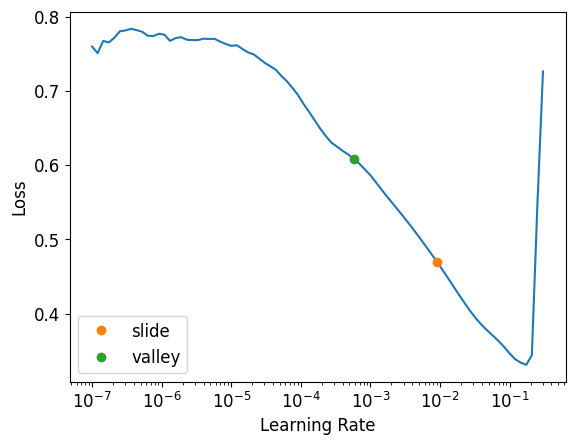

In [21]:
learn = tabular_learner(dls, metrics=R2Score())
learn.lr_find(suggest_funcs=(slide,valley))

In [18]:
%%time
learn.fit_one_cycle(12,lr_max=slice(learn.valley))


AttributeError: 'TabularModel' object has no attribute 'valley'

In [ ]:
%%time
#learn.fit_one_cycle(12,0.02)

In [19]:
dl = learn.dls.test_dl(test_df)

In [20]:
%%time
nn_preds = learn.get_preds(dl=dl)
nn_preds_x = learn.get_preds()[0]
a_preds, _ = learn.get_preds(dl=dl)
nn_preds_y = a_preds.squeeze(1)

CPU times: user 4min 29s, sys: 917 ms, total: 4min 30s
Wall time: 2min 17s


In [21]:
!ls

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


models


In [22]:
learn.export('models/fp_model.pkl')

In [ ]:
#learn.load('fp_model.pkl')

In [23]:
r2_score(y_test,nn_preds_x)

-110.07345504089412

# Neural Network Ensemble

In [ ]:
def ensemble():
    learn = tabular_learner(dls, metrics=RocAucMulti())
    with learn.no_bar(),learn.no_logging(): learn.fit(6, 0.02)
    return learn.get_preds(dl=dl)[0]

In [ ]:
learns = [ensemble() for _ in range(5)]

In [ ]:
ens_preds = torch.stack(learns).mean(0)

In [ ]:
nn_preds_x.shape,ens_preds.shape

In [ ]:
r2_score(y_test,nn_preds_x)

In [ ]:
target_preds = nn_preds[0]

In [ ]:
test_df['FloodProbability'] = target_preds

In [ ]:
test_df.to_csv('submission.csv', columns=['FloodProbability'], index=True)

In [ ]:
submission = pd.read_csv('submission.csv')
submission.head()

In [ ]:
!rm submission.csv

In [ ]:
test_df['FloodProbability'] = target_preds
test_df.to_csv('submission.csv', columns=['FloodProbability'], index=True)

submission = pd.read_csv('submission.csv')
submission.head()

In [ ]:
!ls

# Random Forest Baseline

In [ ]:
rf = RandomForestRegressor(100, min_samples_leaf=3)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))

rf_preds_x = tensor(rf_model.predict(X_test))

mse = mean_absolute_error(y_test, rf_preds_x)
rmse = np.sqrt(mse)

r2_score(y_test,rf_preds_x)

In [ ]:
!ls

# Optimize Params with Optuna

CatBoost - Optuna

In [ ]:
import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score

import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

def objective_catboost(trial):
    params = {
        "iterations": 200,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "random_strength": trial.suggest_int("random_strength", 1, 10),
    }
    model = CatBoostRegressor(**params, silent=True)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)
    cat_predictions = model.predict(X_test)
    r2score = r2_score(y_test, cat_predictions)
    return r2score


study_catboost = optuna.create_study(direction='minimize')
study_catboost.optimize(objective_catboost, n_trials=200)
print(study_catboost.best_params)

LightGBM - Optuna

In [ ]:
%%time

def objective_lgbm(trial):
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 20, 50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    lgb_predictions = model.predict(X_test)
    r2score = r2_score(y_test, lgb_predictions)
    return r2score


study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(objective_lgbm, n_trials=50)
print(study_lgbm.best_params)

In [ ]:
%%time

def objective_lgbm(trial):
    params = {
            'num_leaves': trial.suggest_int('num_leaves', 100, 500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 300, 1200),
            'subsample_for_bin': trial.suggest_int('subsample_for_bin', 20000, 300000),
            'min_child_samples': trial.suggest_int('min_child_samples', 20, 500),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
            'subsample': trial.suggest_float('subsample', 0.25, 1.0),
            'max_depth': trial.suggest_int('max_depth', 1, 15)
            }
    
    model = lgb.LGBMRegressor(**params,verbose=False)
    model.fit(X_train, y_train)
    lgb_predictions = model.predict(X_test)
    r2score = r2_score(y_test, lgb_predictions)
    return r2score


study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(objective_lgbm, n_trials=100)
print(study_lgbm.best_params)

In [41]:
# Function Optuna
def objective(trial):
    # Define parameters to be optimized
    params = {
            'num_leaves': trial.suggest_int('num_leaves', 100, 500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 300, 1200),
            'subsample_for_bin': trial.suggest_int('subsample_for_bin', 20000, 300000),
            'min_child_samples': trial.suggest_int('min_child_samples', 20, 500),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
            'subsample': trial.suggest_float('subsample', 0.25, 1.0),
            'max_depth': trial.suggest_int('max_depth', 1, 15)
            }
    
    # Train the model
    model = LGBMRegressor(**params, objective='regression', random_state=0, device='gpu', verbosity=-1)
    model.fit(X_train, y_train)
    
    lgb_predictions = model.predict(X_test)
    r2score = r2_score(y_test, lgb_predictions)
    return r2score
    
   

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Get the best parameters and best R^2 score
best_params = study.best_params
best_r2 = study.best_value

print("Best R^2 score:", best_r2)
print("Best parameters:", best_params)

[I 2024-05-12 09:05:42,925] A new study created in memory with name: no-name-f399b8af-6dc3-4ff0-a09c-1350d0b2e784
[W 2024-05-12 09:05:42,932] Trial 0 failed with parameters: {'num_leaves': 179, 'learning_rate': 0.21659520680758576, 'n_estimators': 833, 'subsample_for_bin': 285187, 'min_child_samples': 77, 'reg_alpha': 1.9220584655009895e-07, 'reg_lambda': 2.282066621320484, 'colsample_bytree': 0.543450771015672, 'subsample': 0.2824901576804602, 'max_depth': 14} because of the following error: NameError("name 'LGBMRegressor' is not defined").
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_33/2742465432.py", line 18, in objective
    model = LGBMRegressor(**params, objective='regression', random_state=0, device='gpu', verbosity=-1)
NameError: name 'LGBMRegressor' is not defined
[W 2024-05-12 09:05:42,934] Trial 0 failed with value None.


NameError: name 'LGBMRegressor' is not defined

XGBoost - Optuna

In [ ]:
def objective_xgboost(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
    }
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    xgb_predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, xgb_predictions, squared=False)
    return rmse

study_xgboost = optuna.create_study(direction='minimize')
study_xgboost.optimize(objective_xgboost, n_trials=150)
print(study_xgboost.best_params)

# CatBoost Baseline

In [ ]:
#with optuna params
cat_model = CatBoostRegressor(iterations=2000, depth=9, learning_rate= 0.29776650862748444, random_strength=3)
cat_model = cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

#test set preds
cat_preds = tensor(cat_model.predict(test_dl.xs))

#validation set preds
cat_preds_x = tensor(cat_model.predict(X_test))

r2_score(y_test,cat_preds_x)

In [ ]:
print(study_catboost.best_params)

In [ ]:
#with optuna params
cat_model = CatBoostRegressor(iterations=1441, depth=1, learning_rate= 0.01000456241465664, random_strength=10)
cat_model = cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

#test set preds
cat_preds = tensor(cat_model.predict(test_dl.xs))

#validation set preds
cat_preds_x = tensor(cat_model.predict(X_test))

r2_score(y_test,cat_preds_x)

In [ ]:
#with optuna params
cat_model = CatBoostRegressor(iterations=50=00, depth=1, learning_rate= 0.01000456241465664, random_strength=10)
cat_model = cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

#test set preds
cat_preds = tensor(cat_model.predict(test_dl.xs))

#validation set preds
cat_preds_x = tensor(cat_model.predict(X_test))

r2_score(y_test,cat_preds_x)

In [ ]:
#with optuna params
cat_model = CatBoostRegressor(depth=1, learning_rate= 0.01000456241465664, random_strength=10)
cat_model = cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

#test set preds
cat_preds = tensor(cat_model.predict(test_dl.xs))

#validation set preds
cat_preds_x = tensor(cat_model.predict(X_test))

r2_score(y_test,cat_preds_x)

# Light GBM

optuna params

In [ ]:
%%time

def objective_lgbm(trial):
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 20, 50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    lgb_predictions = model.predict(X_test)
    r2score = r2_score(y_test, lgb_predictions)
    return r2score


study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(objective_lgbm, n_trials=50)
print(study_lgbm.best_params)

In [63]:
print(study_lgbm.best_params)

{'num_leaves': 26, 'learning_rate': 0.01001653579832905, 'n_estimators': 110}


In [ ]:
import lightgbm as lgb

def objective_lgbm(trial):
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 20, 50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    lgb_predictions = model.predict(X_test)
    r2score = r2_score(y_test, lgb_predictions)
    return r2score


study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(objective_lgbm, n_trials=100)
print(study_lgbm.best_params)



In [ ]:
import lightgbm as lgb

def objective_lgbm(trial):
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 20, 50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    lgb_predictions = model.predict(X_test)
    r2score = r2_score(y_test, lgb_predictions)
    return r2score


study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(objective_lgbm, n_trials=150)
print(study_lgbm.best_params)



In [ ]:
{'num_leaves': 26, 'learning_rate': 0.01001653579832905, 'n_estimators': 110}
{'num_leaves': 25, 'learning_rate': 0.010094365133109197, 'n_estimators': 100}
{'num_leaves': 20, 'learning_rate': 0.010218030489864638, 'n_estimators': 100} - 150 trials

In [66]:
lgb_model = lgb.LGBMRegressor(num_leaves=26, learning_rate=0.01001653579832905, n_estimators=110)
lgb_model = lgb_model.fit(X_train, y_train)

#test set preds
lgb_preds = tensor(lgb_model.predict(test_dl.xs))

#validation set preds
lgb_preds_x = tensor(lgb_model.predict(X_test))

lgb_score = r2_score(y_test,lgb_preds_x)
lgb_score

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


0.20832613802359756

In [67]:
#100 trials
lgb_model = lgb.LGBMRegressor(num_leaves=25, learning_rate=0.010094365133109197, n_estimators=100)
lgb_model = lgb_model.fit(X_train, y_train)

#test set preds
lgb_preds = tensor(lgb_model.predict(test_dl.xs))

#validation set preds
lgb_preds_x = tensor(lgb_model.predict(X_test))

lgb_score = r2_score(y_test,lgb_preds_x)
lgb_score

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


0.19176752403465236

In [68]:
#150 trials
lgb_model = lgb.LGBMRegressor(num_leaves=20, learning_rate=0.010218030489864638, n_estimators=100)
lgb_model = lgb_model.fit(X_train, y_train)

#test set preds
lgb_preds = tensor(lgb_model.predict(test_dl.xs))

#validation set preds
lgb_preds_x = tensor(lgb_model.predict(X_test))

lgb_score = r2_score(y_test,lgb_preds_x)
lgb_score

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


0.18195404368792867

In [44]:
lgb_model = lgb.LGBMRegressor(num_leaves=435, learning_rate=0.0137267854143469, n_estimators=380, max_depth=1,min_child_samples=171, subsample_for_bin=161411, reg_alpha=4.885489650124004, reg_lambda=0.3204538963056391, colsample_bytree =  0.8025591720341736, subsample= 0.8291001995890841)
lgb_model = lgb_model.fit(X_train, y_train)

#test set preds
lgb_preds = tensor(lgb_model.predict(test_dl.xs))

#validation set preds
lgb_preds_x = tensor(lgb_model.predict(X_test))

lgb_score = r2_score(y_test,lgb_preds_x)
lgb_score

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.248206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


0.2013376939903836

In [45]:
lgb_model = lgb.LGBMRegressor(num_leaves=435, learning_rate=0.0137267854143469, n_estimators=380, max_depth=1, boosting_type='gbdt',min_child_samples=171, random_state=27,subsample_for_bin=161411, reg_alpha=4.885489650124004, reg_lambda=0.3204538963056391, colsample_bytree =  0.8025591720341736, subsample= 0.8291001995890841)
lgb_model = lgb_model.fit(X_train, y_train)

#test set preds
lgb_preds = tensor(lgb_model.predict(test_dl.xs))

#validation set preds
lgb_preds_x = tensor(lgb_model.predict(X_test))

lgb_score = r2_score(y_test,lgb_preds_x)
lgb_score

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.246940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


0.2013377326257112

Initial baseline

In [36]:
lgb_model = lgb.LGBMRegressor(num_leaves=500, learning_rate=0.02956613668999794, n_estimators=483, max_depth=82, boosting_type='gbdt',min_child_samples=90, random_state=27,subsample_for_bin=20698, reg_alpha=1.12032585776774e-09, reg_lambda=3.2869705488456358, colsample_bytree =  0.5441783735468184, subsample= 0.9370755150709044)
lgb_model = lgb_model.fit(X_train, y_train)

#test set preds
lgb_preds = tensor(lgb_model.predict(test_dl.xs))

#validation set preds
lgb_preds_x = tensor(lgb_model.predict(X_test))

lgb_score = r2_score(y_test,lgb_preds_x)
lgb_score

[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.248360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


0.8422927669686152

In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['FloodProbability'] = lgb_preds
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')

In [ ]:
sub

# XGBoost

In [ ]:
xgb_model = xgb.XGBRegressor(n_estimators = 196, max_depth=5, learning_rate=0.1461774202844157, subsample= 0.6649609199174655)
xgb_model = xgb_model.fit(X_train, y_train)

xgb_preds = tensor(xgb_model.predict(test_dl.xs))

xgb_preds_x = tensor(xgb_model.predict(X_test))

r2_score(y_test,xgb_preds_x)

# General Ensemble

In [ ]:
nn_preds_m = nn_preds_x.squeeze()

In [ ]:
#for r2_Score testing
general_preds = (lgb_preds_x + xgb_preds_x + cat_preds_x + nn_preds_m)/4
general_preds

In [ ]:
#for r2_Score testing
general_preds = ( cat_preds_x + nn_preds_m)/2
general_preds

In [ ]:
r2_score(y_test,general_preds)

In [ ]:
r2_score(y_test,general_preds)

In [ ]:
!ls

In [ ]:
general_preds.shape

In [ ]:
#use for submission
general_preds = (cat_preds + nn_preds_y)/2             
general_preds

# Scoring

In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['FloodProbability'] = general_preds
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')

In [ ]:
!ls

In [ ]:
!rm submission.csv

In [ ]:
def objective_lgbm(trial):
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 20, 50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    lgb_predictions = model.predict(X_test)
    r2score = r2_score(y_test, lgb_predictions)
    return r2score

# Create a study
study_lgbm = optuna.create_study(direction='minimize')

# Convert the study to a distributed study
study_lgbm = optuna_distributed.from_study(study_lgbm)

# Run the optimization with parallel processing
num_parallel_jobs = 4 # Adjust this based on your system's capabilities
study_lgbm.optimize(objective_lgbm, n_trials=100, n_jobs=num_parallel_jobs)

print(study_lgbm.best_params)
